### Importe de librerias 


In [1]:
#Para poner la barra de progreso durante el entrenamiento 
!pip install tqdm
import sys
!"{sys.executable}" -m pip install tqdm 

In [2]:
import pennylane as qml
import numpy as np
from pennylane import numpy as pnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import pickle

### Definición del dispositivo y número de qubits

Un dispositivo cuántico es un objeto que representa el backend donde se ejecuta el circuito cuántico.

qml.device carga un dispositivo cuántico particular.

'default.qubit':un simulador de estados puros.

'default.mixed':un simulador de estados mezclados.

In [3]:
#Definición del dispositivo cuántico
dev = qml.device("default.mixed", wires=4)

### Arquitectura del Circuito 


Un QNode es una función que contiene al circuito variacional y el dispositivo computacional en el que se ejecuta.

interface="autograd": le dice a PennyLane que los parámetros serán diferenciables con autograd (la librería automática de derivación).

qml.QubitDensityMatrix requiere el estado total del sistema completo.

Toma el estado base (qubits 0 y 1 en |00⟩⟨00|) y lo combina con el estado rho (en qubits 2 y 3) para formar el estado de los 4 qubits juntos.


In [4]:

@qml.qnode(dev) #Decorador para definir el circuito cuántico
def Circuit(params, rho):
    # Crear estado |00⟩⟨00| para qubits 0 y 1
    base = pnp.zeros((4,4), dtype=complex)
    base[0,0] = 1.0 # Para poner la primera entrada de la matriz en 1 y el resto en 0
    
    # Producto tensorial para obtener estado total de 4 qubits
    full_state = pnp.kron(base, rho)
    
    # Usar en el dispositivo de 4 qubits
    qml.QubitDensityMatrix(full_state, wires=[0, 1, 2, 3])
    
    qml.Rot(params[0], params[1], params[2], wires=0)
    qml.Rot(params[3], params[4], params[5], wires=1)
    qml.Rot(params[6], params[7], params[8], wires=2)
    qml.Rot(params[9], params[10], params[11], wires=3)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[3, 0])

    # La compuerta v1 opera si el qubit de control (0) está en |1⟩


    qml.PauliX(wires=0)

    qml.ctrl(qml.Rot(params[12], params[13], params[14], wires=1), control=0)
    qml.ctrl(qml.Rot(params[15], params[16], params[17], wires=2), control=0)
    qml.ctrl(qml.Rot(params[18], params[19], params[20], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)

    qml.PauliX(wires=0)

    # La compuerta v2 opera si el qubit de control (0) está en |0⟩


    qml.ctrl(qml.Rot(params[21], params[22], params[23], wires=1), control=0)
    qml.ctrl(qml.Rot(params[24], params[25], params[26], wires=2), control=0)
    qml.ctrl(qml.Rot(params[27], params[28], params[29], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)    
    
    return qml.probs(wires=[0, 1]) 



### Definición de las familias 

dtype= complex porque aunque las matrices se definan para parametros a y b reales, 
la evolución del sistema si puede introducir números complejos.

In [5]:
def ρ1(a):
    
    psi1 = pnp.array([np.sqrt(1 - a*a), 0.0, a, 0.0], dtype=complex)
    rho1 = pnp.outer(psi1, psi1.conj())
    return rho1, 1

def ρ2(b):

    psi2 = pnp.array([0.0, np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    psi3 = pnp.array([0.0, -np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    rho2 = 0.5 * np.outer(psi2, psi2.conj()) + 0.5 * np.outer(psi3, psi3.conj())

    return rho2, 2
    

### Conjunto de Datos de Prueba 

Para el caso de la distribución uniforme

In [6]:
np.random.seed(2)
n_test = 10000
data_test = []

# Clase 1: rho1, etiqueta = 1
a_test = np.random.uniform(0, 1, int(n_test/2))
for a in a_test:
    rho, label = ρ1(a)
    data_test.append((rho, label))

# Clase 2: rho2, etiqueta = 2
b_test = np.random.uniform(0, 1, int(n_test/2))
for b in b_test:
    rho, label = ρ2(b)
    data_test.append((rho, label))

### Conjunto de Datos de Entrenamiento 


In [7]:
np.random.seed(90701)
n_samples = 50
data = []

# Familia 1 → usa ρ1(a), etiqueta = 1
a_values = np.random.uniform(0, 1, int(n_samples/2))
for a in a_values:
    rho, label = ρ1(a)  # rho es matriz 4x4, label = 1
    data.append((rho, label))

# Familia 2 → usa ρ2(b), etiqueta = 2
b_values = np.random.uniform(0, 1, int(n_samples/2))
for b in b_values:
    rho, label = ρ2(b)  # rho es matriz 4x4, label = 2
    data.append((rho, label))

# Mezclar y dividir: 80% entrenamiento, 20% validación
data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

### Función de Pérdida 


In [8]:
# Funciones de pérdida

# Clasificación mínimo error (Probabilidad de inconclusión casi nula)

alpha_err = 15  # penaliza los errores
alpha_inc = 2 # penaliza los resultados inconclusos


# Función de pérdida para una muestra según el label:
# label 1: familia 1 se espera que los outcomes 00 y 10 sean correctos.
# label 2: familia 2 se espera que el outcome 01 sea correcto.

def sample_loss(params, rho, label):
    
    probs = Circuit(params, rho)
    # |00> -> probs[0], |01> -> probs[1], |10> -> probs[2], |11> -> probs[3]
    if label == 1:
        # Familia 1 => éxito: (|00>, |10>), error: |01>, inconcluso: |11>
        p_suc = (probs[0] + probs[2])
        p_err = probs[1]
        p_inc = probs[3]
    else:
        # Familia 2 => éxito: |01>, error: (|00>, |10>), inconcluso: |11>
        p_suc = probs[1]
        p_err = probs[0] + probs[2]
        p_inc = probs[3]
        
    return (
    pnp.abs(p_suc - 1.0)
    + alpha_err * pnp.abs(p_err - 0.0)
    + alpha_inc * pnp.abs(p_inc - 0.0)
    )

# Función global de pérdida que promedia sobre el conjunto de muestras

def loss(params, samples):
    total = pnp.array(0.0, requires_grad=True) #iniciar el acumulador del costo total,
    #asegurar que ese acumulador soporta derivación automática, y permitir que luego PennyLane optimice los parámetros con gradientes.  

    for (rho, label) in samples:
        total = total + sample_loss(params, rho, label)

    avg = total / len(samples)           
    return avg  

In [9]:
def get_probabilities(params, rho, label):
    """Calcula las probabilidades de salida del circuito, dada la matriz de densidad."""
    
    return Circuit(params, rho)


### Evaluación del modelo

In [10]:
def evaluate_model(params, samples):
    """Evalúa tasas promedio de éxito, error e inconcluso en cada familia."""
    
    # Separar por familia
    S1 = [rho for (rho, label) in samples if label == 1]
    S2 = [rho for (rho, label) in samples if label == 2]

    total_suc_1, total_err_1, total_inc_1 = 0, 0, 0
    total_suc_2, total_err_2, total_inc_2 = 0, 0, 0

    for rho in S1:
        probs = get_probabilities(params, rho, 1)
        total_suc_1 += probs[0] + probs[2]  # éxito
        total_err_1 += probs[1]
        total_inc_1 += probs[3]

    for rho in S2:
        probs = get_probabilities(params, rho, 2)
        total_suc_2 += probs[1]             # éxito
        total_err_2 += probs[0] + probs[2]
        total_inc_2 += probs[3]

    # Promedios por familia
    n1, n2 = len(S1), len(S2)
    suc = (total_suc_1 + total_suc_2) / (n1 + n2)
    err = (total_err_1 + total_err_2) / (n1 + n2)
    inc = (total_inc_1 + total_inc_2) / (n1 + n2)

    return suc, err, inc


In [11]:
def get_batches(data, batch_size):
    # Asegurar que batch_size sea al menos 1
    batch_size = max(1, int(batch_size))
    
    # Mezclar los datos
    data_shuffled = random.sample(data, len(data))
    
    # Crear los lotes
    return [data_shuffled[i:i+batch_size] for i in range(0, len(data), batch_size)]


### Entrenamiento del modelo


params, curr_loss = opt.step_and_cost(lambda v: loss(v, data_train), params)

opt: Optimizador
.step_and_cost(...): Método que actualiza los parámetros y devuelve el valor de la función de costo


Calcula el valor de la función de la función de costo (loss(...)) para los parámetros actuales.
Calcula el gradiente de esa función de costo con respecto a los parámetros.
Actualiza los parámetros en la dirección que reduce la función de costo.

Devuelve:

params: los nuevos parámetros después de actualizar.

curr_loss: el valor actual de la función de costo.

La función lambda hace que el optimizador calcule la función de costo con los parámetros v usando el conjunto de datos data_train que ya está fijado.



In [12]:
opt = qml.AdamOptimizer(stepsize=0.01)
n_iter = 1000
batch_size = int(len(data_train)*0.2)
val_batch_size=int(0.2*batch_size)

initial_params = np.random.uniform(0, 2 * np.pi, 30)
params = pnp.array(initial_params, requires_grad=True)

# Early stopping
patience = 100
min_delta = 1e-6
best_val_loss = float('inf')
patience_counter = 0

# Historiales
loss_history = []
val_loss_history = []
train_suc_history = []
train_err_history = []
train_inc_history = []
test_suc_history = []
test_err_history = []
test_inc_history = []

for it in tqdm(range(n_iter), desc="Entrenando"):
    
    # Seleccionar un batch aleatorio de data_train
    batch = random.sample(data_train, batch_size)
    
    # Paso de entrenamiento con el batch
    params, train_loss = opt.step_and_cost(lambda v: loss(v, batch), params)
    
    # Evaluación en validación
    val_batches = get_batches(data_val, val_batch_size)
    val_loss = 0
    for vb in val_batches:
        val_loss += loss(params, vb) * len(vb)
    val_loss /= len(data_val)




    # Early stopping
    if best_val_loss - val_loss > min_delta:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"⏹️ Early stopping en iteración {it+1}. Mejor pérdida de validación: {best_val_loss:.6f}")
        break

    # Evaluación en train y test
    suc_train, err_train, inc_train = evaluate_model(params, data_train)
    suc_test, err_test, inc_test = evaluate_model(params, data_test)

    # Guardar métricas
    loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_suc_history.append(suc_train)
    train_err_history.append(err_train)
    train_inc_history.append(inc_train)
    test_suc_history.append(suc_test)
    test_err_history.append(err_test)
    test_inc_history.append(inc_test)

    if (it + 1) % 50 == 0:
        print(f"Iter {it+1:3d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
              f"train_suc={suc_train:.3f}, train_err={err_train:.3f}, train_inc={inc_train:.3f} | "
              f"test_suc={suc_test:.3f}, test_err={err_test:.3f}, test_inc={inc_test:.3f}")

# Final
print("\nParámetros entrenados:")
print(params)

print("\nResultados finales en el conjunto de prueba:")
print(f"  Éxito promedio     = {suc_test:.4f}")
print(f"  Error promedio     = {err_test:.4f}")
print(f"  Inconcluso promedio = {inc_test:.4f}")




Entrenando:   0%|          | 0/1000 [00:00<?, ?it/s]

Entrenando:   0%|          | 1/1000 [07:36<126:48:14, 456.95s/it]

Entrenando:   0%|          | 2/1000 [15:14<126:46:07, 457.28s/it]

Entrenando:   0%|          | 3/1000 [22:30<123:58:18, 447.64s/it]

Entrenando:   0%|          | 4/1000 [29:33<121:09:09, 437.90s/it]

Entrenando:   0%|          | 5/1000 [36:49<120:49:56, 437.18s/it]

Entrenando:   1%|          | 6/1000 [43:44<118:36:39, 429.58s/it]

Entrenando:   1%|          | 7/1000 [50:50<118:12:52, 428.57s/it]

Entrenando:   1%|          | 8/1000 [57:47<117:02:17, 424.74s/it]

Entrenando:   1%|          | 9/1000 [1:04:44<116:16:10, 422.37s/it]

Entrenando:   1%|          | 10/1000 [1:11:47<116:13:31, 422.64s/it]

Entrenando:   1%|          | 11/1000 [1:18:45<115:42:02, 421.16s/it]

Entrenando:   1%|          | 12/1000 [1:25:42<115:13:39, 419.86s/it]

Entrenando:   1%|▏         | 13/1000 [1:32:47<115:32:20, 421.42s/it]

Entrenando:   1%|▏         | 14/1000 [1:39:43<114:57:46, 419.74s/it]

Entrenando:   2%|▏         | 15/1000 [1:46:39<114:33:36, 418.70s/it]

Entrenando:   2%|▏         | 16/1000 [1:53:37<114:21:27, 418.38s/it]

Entrenando:   2%|▏         | 17/1000 [2:00:32<114:01:24, 417.58s/it]

Entrenando:   2%|▏         | 18/1000 [2:07:30<113:53:54, 417.55s/it]

Entrenando:   2%|▏         | 19/1000 [2:14:56<116:06:44, 426.10s/it]

Entrenando:   2%|▏         | 20/1000 [2:21:52<115:08:49, 422.99s/it]

Entrenando:   2%|▏         | 21/1000 [2:29:08<116:07:27, 427.01s/it]

Entrenando:   2%|▏         | 22/1000 [2:36:05<115:08:36, 423.84s/it]

Entrenando:   2%|▏         | 23/1000 [2:43:00<114:20:09, 421.30s/it]

Entrenando:   2%|▏         | 24/1000 [2:49:56<113:47:48, 419.74s/it]

Entrenando:   2%|▎         | 25/1000 [2:56:51<113:18:56, 418.40s/it]

Entrenando:   3%|▎         | 26/1000 [3:03:48<113:05:16, 417.98s/it]

Entrenando:   3%|▎         | 27/1000 [3:11:27<116:15:11, 430.13s/it]

Entrenando:   3%|▎         | 28/1000 [3:18:23<115:01:20, 426.01s/it]

Entrenando:   3%|▎         | 29/1000 [3:25:26<114:37:57, 425.00s/it]

Entrenando:   3%|▎         | 30/1000 [3:32:36<114:58:12, 426.69s/it]

Entrenando:   3%|▎         | 31/1000 [3:39:34<114:05:36, 423.88s/it]

Entrenando:   3%|▎         | 32/1000 [3:46:35<113:45:39, 423.08s/it]

Entrenando:   3%|▎         | 33/1000 [3:53:34<113:18:13, 421.81s/it]

Entrenando:   3%|▎         | 34/1000 [4:00:32<112:51:37, 420.60s/it]

Entrenando:   4%|▎         | 35/1000 [4:07:57<114:45:47, 428.13s/it]

Entrenando:   4%|▎         | 36/1000 [4:14:53<113:37:47, 424.34s/it]

Entrenando:   4%|▎         | 37/1000 [4:21:49<112:53:22, 422.02s/it]

Entrenando:   4%|▍         | 38/1000 [4:28:46<112:21:41, 420.48s/it]

Entrenando:   4%|▍         | 39/1000 [4:35:55<112:55:18, 423.02s/it]

Entrenando:   4%|▍         | 40/1000 [4:42:52<112:18:11, 421.14s/it]

Entrenando:   4%|▍         | 41/1000 [4:49:55<112:22:11, 421.83s/it]

Entrenando:   4%|▍         | 42/1000 [4:56:54<111:58:32, 420.79s/it]

Entrenando:   4%|▍         | 43/1000 [5:03:50<111:27:38, 419.29s/it]

Entrenando:   4%|▍         | 44/1000 [5:10:47<111:10:48, 418.67s/it]

Entrenando:   4%|▍         | 45/1000 [5:17:44<110:56:20, 418.20s/it]

Entrenando:   5%|▍         | 46/1000 [5:24:57<111:59:31, 422.61s/it]

Entrenando:   5%|▍         | 47/1000 [5:31:52<111:17:40, 420.42s/it]

Entrenando:   5%|▍         | 48/1000 [5:38:51<111:01:10, 419.82s/it]

Entrenando:   5%|▍         | 49/1000 [5:45:49<110:45:41, 419.29s/it]

Entrenando:   5%|▌         | 50/1000 [5:52:46<110:29:47, 418.72s/it]

Iter  50: train_loss=3.5733, val_loss=6.5786, train_suc=0.458, train_err=0.266, train_inc=0.276 | test_suc=0.418, test_err=0.279, test_inc=0.302


Entrenando:   5%|▌         | 51/1000 [5:59:41<110:05:54, 417.66s/it]

Entrenando:   5%|▌         | 52/1000 [6:06:46<110:31:56, 419.74s/it]

Entrenando:   5%|▌         | 53/1000 [6:13:45<110:22:00, 419.56s/it]

Entrenando:   5%|▌         | 54/1000 [6:20:41<109:59:33, 418.58s/it]

Entrenando:   6%|▌         | 55/1000 [6:27:36<109:35:17, 417.48s/it]

Entrenando:   6%|▌         | 56/1000 [6:34:51<110:48:25, 422.57s/it]

Entrenando:   6%|▌         | 57/1000 [6:41:48<110:15:32, 420.93s/it]

Entrenando:   6%|▌         | 58/1000 [6:48:47<109:59:54, 420.38s/it]

Entrenando:   6%|▌         | 59/1000 [6:55:44<109:36:07, 419.31s/it]

Entrenando:   6%|▌         | 60/1000 [7:02:41<109:20:17, 418.74s/it]

Entrenando:   6%|▌         | 61/1000 [7:09:38<109:06:56, 418.34s/it]

Entrenando:   6%|▌         | 62/1000 [7:16:34<108:49:28, 417.66s/it]

Entrenando:   6%|▋         | 63/1000 [7:23:41<109:23:29, 420.29s/it]

Entrenando:   6%|▋         | 64/1000 [7:31:07<111:16:37, 427.99s/it]

Entrenando:   6%|▋         | 65/1000 [7:38:34<112:39:09, 433.74s/it]

Entrenando:   7%|▋         | 66/1000 [7:45:37<111:42:39, 430.58s/it]

Entrenando:   7%|▋         | 67/1000 [7:52:43<111:12:57, 429.13s/it]

Entrenando:   7%|▋         | 68/1000 [7:59:49<110:53:06, 428.31s/it]

Entrenando:   7%|▋         | 69/1000 [8:06:46<109:53:47, 424.95s/it]

Entrenando:   7%|▋         | 70/1000 [8:13:46<109:19:29, 423.19s/it]

Entrenando:   7%|▋         | 71/1000 [8:20:41<108:38:46, 421.02s/it]

Entrenando:   7%|▋         | 72/1000 [8:27:38<108:12:56, 419.80s/it]

Entrenando:   7%|▋         | 73/1000 [8:34:35<107:51:59, 418.90s/it]

Entrenando:   7%|▋         | 74/1000 [8:41:34<107:42:41, 418.75s/it]

Entrenando:   8%|▊         | 75/1000 [8:48:33<107:37:18, 418.85s/it]

Entrenando:   8%|▊         | 76/1000 [8:55:29<107:19:02, 418.12s/it]

Entrenando:   8%|▊         | 77/1000 [9:02:28<107:16:53, 418.43s/it]

Entrenando:   8%|▊         | 78/1000 [9:09:27<107:10:15, 418.45s/it]

Entrenando:   8%|▊         | 79/1000 [9:16:24<106:56:44, 418.03s/it]

Entrenando:   8%|▊         | 80/1000 [9:23:50<108:59:08, 426.47s/it]

Entrenando:   8%|▊         | 81/1000 [9:30:53<108:38:01, 425.55s/it]

Entrenando:   8%|▊         | 82/1000 [9:37:50<107:51:23, 422.97s/it]

Entrenando:   8%|▊         | 83/1000 [9:44:47<107:17:08, 421.19s/it]

Entrenando:   8%|▊         | 84/1000 [9:52:21<109:39:26, 430.97s/it]

Entrenando:   8%|▊         | 85/1000 [9:59:58<111:31:46, 438.80s/it]

Entrenando:   9%|▊         | 86/1000 [10:08:14<115:45:03, 455.91s/it]

Entrenando:   9%|▊         | 87/1000 [10:15:55<116:01:31, 457.49s/it]

Entrenando:   9%|▉         | 88/1000 [10:23:31<115:45:09, 456.92s/it]

Entrenando:   9%|▉         | 89/1000 [10:31:08<115:39:00, 457.02s/it]

Entrenando:   9%|▉         | 90/1000 [10:38:45<115:30:22, 456.95s/it]

Entrenando:   9%|▉         | 91/1000 [10:47:02<118:23:14, 468.86s/it]

Entrenando:   9%|▉         | 92/1000 [10:55:18<120:22:01, 477.23s/it]

Entrenando:   9%|▉         | 93/1000 [11:03:33<121:33:41, 482.49s/it]

Entrenando:   9%|▉         | 94/1000 [11:11:21<120:17:57, 478.01s/it]

Entrenando:  10%|▉         | 95/1000 [11:18:57<118:32:11, 471.53s/it]

Entrenando:  10%|▉         | 96/1000 [11:26:34<117:17:35, 467.10s/it]

Entrenando:  10%|▉         | 97/1000 [11:33:30<113:21:16, 451.91s/it]

Entrenando:  10%|▉         | 98/1000 [11:41:06<113:32:24, 453.15s/it]

Entrenando:  10%|▉         | 99/1000 [11:48:34<112:59:54, 451.49s/it]

Entrenando:  10%|█         | 100/1000 [11:55:30<110:10:58, 440.73s/it]

Iter 100: train_loss=3.0293, val_loss=4.9205, train_suc=0.512, train_err=0.209, train_inc=0.279 | test_suc=0.465, test_err=0.206, test_inc=0.328


Entrenando:  10%|█         | 101/1000 [12:02:25<108:10:00, 433.15s/it]

Entrenando:  10%|█         | 102/1000 [12:09:30<107:26:43, 430.74s/it]

Entrenando:  10%|█         | 103/1000 [12:16:27<106:15:55, 426.48s/it]

Entrenando:  10%|█         | 104/1000 [12:24:02<108:16:59, 435.07s/it]

Entrenando:  10%|█         | 105/1000 [12:30:58<106:47:35, 429.56s/it]

Entrenando:  11%|█         | 106/1000 [12:37:55<105:44:16, 425.79s/it]

Entrenando:  11%|█         | 107/1000 [12:45:02<105:41:32, 426.08s/it]

Entrenando:  11%|█         | 108/1000 [12:52:09<105:38:37, 426.36s/it]

Entrenando:  11%|█         | 109/1000 [12:59:46<107:45:02, 435.36s/it]

Entrenando:  11%|█         | 110/1000 [13:06:42<106:12:50, 429.63s/it]

Entrenando:  11%|█         | 111/1000 [13:13:38<105:04:38, 425.51s/it]

Entrenando:  11%|█         | 112/1000 [13:20:33<104:13:03, 422.50s/it]

Entrenando:  11%|█▏        | 113/1000 [13:27:28<103:33:16, 420.29s/it]

Entrenando:  11%|█▏        | 114/1000 [13:34:55<105:21:40, 428.10s/it]

Entrenando:  12%|█▏        | 115/1000 [13:42:29<107:12:03, 436.07s/it]

Entrenando:  12%|█▏        | 116/1000 [13:50:08<108:44:18, 442.83s/it]

Entrenando:  12%|█▏        | 117/1000 [13:58:23<112:29:40, 458.64s/it]

Entrenando:  12%|█▏        | 118/1000 [14:05:33<110:13:41, 449.91s/it]

Entrenando:  12%|█▏        | 119/1000 [14:12:32<107:48:22, 440.52s/it]

Entrenando:  12%|█▏        | 120/1000 [14:19:27<105:48:40, 432.86s/it]

Entrenando:  12%|█▏        | 121/1000 [14:26:23<104:30:24, 428.01s/it]

Entrenando:  12%|█▏        | 122/1000 [14:33:18<103:25:14, 424.05s/it]

Entrenando:  12%|█▏        | 123/1000 [14:40:28<103:44:10, 425.83s/it]

Entrenando:  12%|█▏        | 124/1000 [14:47:26<103:00:55, 423.35s/it]

Entrenando:  12%|█▎        | 125/1000 [14:54:22<102:24:42, 421.35s/it]

Entrenando:  13%|█▎        | 126/1000 [15:01:19<101:59:11, 420.08s/it]

Entrenando:  13%|█▎        | 127/1000 [15:08:15<101:31:43, 418.68s/it]

Entrenando:  13%|█▎        | 128/1000 [15:15:11<101:15:20, 418.03s/it]

Entrenando:  13%|█▎        | 129/1000 [15:22:50<104:03:10, 430.07s/it]

Entrenando:  13%|█▎        | 130/1000 [15:29:59<103:53:16, 429.88s/it]

Entrenando:  13%|█▎        | 131/1000 [15:37:00<103:06:52, 427.17s/it]

Entrenando:  13%|█▎        | 132/1000 [15:44:01<102:34:06, 425.40s/it]

Entrenando:  13%|█▎        | 133/1000 [15:51:33<104:21:06, 433.29s/it]

Entrenando:  13%|█▎        | 134/1000 [15:58:30<103:04:26, 428.48s/it]

Entrenando:  14%|█▎        | 135/1000 [16:05:27<102:05:48, 424.91s/it]

Entrenando:  14%|█▎        | 136/1000 [16:13:04<104:16:39, 434.49s/it]

Entrenando:  14%|█▎        | 137/1000 [16:20:00<102:50:10, 428.98s/it]

Entrenando:  14%|█▍        | 138/1000 [16:27:22<103:39:10, 432.89s/it]

Entrenando:  14%|█▍        | 139/1000 [16:34:30<103:12:09, 431.51s/it]

Entrenando:  14%|█▍        | 140/1000 [16:41:26<101:57:01, 426.77s/it]

Entrenando:  14%|█▍        | 141/1000 [16:49:03<104:01:23, 435.95s/it]

Entrenando:  14%|█▍        | 142/1000 [16:55:58<102:24:14, 429.67s/it]

Entrenando:  14%|█▍        | 143/1000 [17:02:53<101:15:20, 425.34s/it]

Entrenando:  14%|█▍        | 144/1000 [17:09:48<100:24:35, 422.29s/it]

Entrenando:  14%|█▍        | 145/1000 [17:16:43<99:46:38, 420.12s/it] 

Entrenando:  15%|█▍        | 146/1000 [17:23:38<99:15:38, 418.43s/it]

Entrenando:  15%|█▍        | 147/1000 [17:30:35<99:04:09, 418.11s/it]

Entrenando:  15%|█▍        | 148/1000 [17:37:32<98:50:00, 417.61s/it]

Entrenando:  15%|█▍        | 149/1000 [17:44:27<98:33:48, 416.96s/it]

Entrenando:  15%|█▌        | 150/1000 [17:51:33<99:05:22, 419.67s/it]

Iter 150: train_loss=2.3904, val_loss=4.0173, train_suc=0.552, train_err=0.183, train_inc=0.266 | test_suc=0.501, test_err=0.170, test_inc=0.328


Entrenando:  15%|█▌        | 151/1000 [17:58:43<99:39:13, 422.56s/it]

Entrenando:  15%|█▌        | 152/1000 [18:05:38<99:01:30, 420.39s/it]

Entrenando:  15%|█▌        | 153/1000 [18:12:53<99:55:54, 424.74s/it]

Entrenando:  15%|█▌        | 154/1000 [18:20:00<99:59:46, 425.52s/it]

Entrenando:  16%|█▌        | 155/1000 [18:27:10<100:09:55, 426.74s/it]

Entrenando:  16%|█▌        | 156/1000 [18:34:45<102:05:06, 435.43s/it]

Entrenando:  16%|█▌        | 157/1000 [18:41:40<100:30:51, 429.24s/it]

Entrenando:  16%|█▌        | 158/1000 [18:48:37<99:32:00, 425.56s/it] 

Entrenando:  16%|█▌        | 159/1000 [18:55:32<98:39:32, 422.32s/it]

Entrenando:  16%|█▌        | 160/1000 [19:02:59<100:17:46, 429.84s/it]

Entrenando:  16%|█▌        | 161/1000 [19:09:54<99:07:10, 425.30s/it] 

Entrenando:  16%|█▌        | 162/1000 [19:17:11<99:49:36, 428.85s/it]

Entrenando:  16%|█▋        | 163/1000 [19:24:06<98:44:38, 424.71s/it]

Entrenando:  16%|█▋        | 164/1000 [19:31:43<100:50:31, 434.25s/it]

Entrenando:  16%|█▋        | 165/1000 [19:38:39<99:26:33, 428.73s/it] 

Entrenando:  17%|█▋        | 166/1000 [19:45:34<98:25:41, 424.87s/it]

Entrenando:  17%|█▋        | 167/1000 [19:52:48<98:54:20, 427.44s/it]

Entrenando:  17%|█▋        | 168/1000 [20:00:24<100:45:50, 436.00s/it]

Entrenando:  17%|█▋        | 169/1000 [20:07:48<101:13:28, 438.52s/it]

Entrenando:  17%|█▋        | 170/1000 [20:14:45<99:33:58, 431.85s/it] 

Entrenando:  17%|█▋        | 171/1000 [20:21:43<98:29:36, 427.72s/it]

Entrenando:  17%|█▋        | 172/1000 [20:28:38<97:30:13, 423.93s/it]

Entrenando:  17%|█▋        | 173/1000 [20:35:54<98:12:34, 427.51s/it]

Entrenando:  17%|█▋        | 174/1000 [20:42:49<97:15:41, 423.90s/it]

Entrenando:  18%|█▊        | 175/1000 [20:50:24<99:17:42, 433.29s/it]

Entrenando:  18%|█▊        | 176/1000 [20:58:01<100:48:56, 440.46s/it]

Entrenando:  18%|█▊        | 177/1000 [21:05:39<101:53:16, 445.68s/it]

Entrenando:  18%|█▊        | 178/1000 [21:13:40<104:09:18, 456.15s/it]

Entrenando:  18%|█▊        | 179/1000 [21:21:53<106:35:20, 467.38s/it]

Entrenando:  18%|█▊        | 180/1000 [21:30:11<108:32:03, 476.49s/it]

Entrenando:  18%|█▊        | 181/1000 [21:38:06<108:18:07, 476.05s/it]

Entrenando:  18%|█▊        | 182/1000 [21:45:43<106:51:43, 470.30s/it]

Entrenando:  18%|█▊        | 183/1000 [21:53:20<105:50:08, 466.35s/it]

Entrenando:  18%|█▊        | 184/1000 [22:00:58<105:07:33, 463.79s/it]

Entrenando:  18%|█▊        | 185/1000 [22:08:35<104:32:54, 461.81s/it]

Entrenando:  19%|█▊        | 186/1000 [22:16:12<104:03:53, 460.24s/it]

Entrenando:  19%|█▊        | 187/1000 [22:24:03<104:39:20, 463.42s/it]

Entrenando:  19%|█▉        | 188/1000 [22:32:18<106:39:38, 472.88s/it]

Entrenando:  19%|█▉        | 189/1000 [22:40:18<107:01:20, 475.07s/it]

Entrenando:  19%|█▉        | 190/1000 [22:47:55<105:41:53, 469.77s/it]

Entrenando:  19%|█▉        | 191/1000 [22:55:32<104:41:30, 465.87s/it]

Entrenando:  19%|█▉        | 192/1000 [23:03:24<105:00:38, 467.87s/it]

Entrenando:  19%|█▉        | 193/1000 [23:11:04<104:17:59, 465.28s/it]

Entrenando:  19%|█▉        | 194/1000 [23:18:40<103:34:46, 462.64s/it]

Entrenando:  20%|█▉        | 195/1000 [23:26:37<104:23:37, 466.85s/it]

Entrenando:  20%|█▉        | 196/1000 [23:34:13<103:33:40, 463.71s/it]

Entrenando:  20%|█▉        | 197/1000 [23:42:30<105:38:34, 473.62s/it]

Entrenando:  20%|█▉        | 198/1000 [23:50:45<106:57:51, 480.14s/it]

Entrenando:  20%|█▉        | 199/1000 [23:58:22<105:17:42, 473.24s/it]

Entrenando:  20%|██        | 200/1000 [24:05:21<101:32:25, 456.93s/it]

Iter 200: train_loss=3.1258, val_loss=3.9020, train_suc=0.560, train_err=0.178, train_inc=0.262 | test_suc=0.509, test_err=0.165, test_inc=0.326


Entrenando:  20%|██        | 201/1000 [24:12:20<98:50:18, 445.33s/it] 

Entrenando:  20%|██        | 202/1000 [24:19:17<96:50:36, 436.89s/it]

Entrenando:  20%|██        | 203/1000 [24:26:17<95:37:57, 431.97s/it]

Entrenando:  20%|██        | 204/1000 [24:33:40<96:13:11, 435.16s/it]

Entrenando:  20%|██        | 205/1000 [24:40:35<94:47:14, 429.23s/it]

Entrenando:  21%|██        | 206/1000 [24:47:32<93:51:44, 425.57s/it]

Entrenando:  21%|██        | 207/1000 [24:54:30<93:12:29, 423.14s/it]

Entrenando:  21%|██        | 208/1000 [25:01:43<93:45:28, 426.17s/it]

Entrenando:  21%|██        | 209/1000 [25:09:18<95:33:42, 434.92s/it]

Entrenando:  21%|██        | 210/1000 [25:16:20<94:33:39, 430.91s/it]

Entrenando:  21%|██        | 211/1000 [25:23:17<93:32:05, 426.78s/it]

Entrenando:  21%|██        | 212/1000 [25:30:15<92:50:59, 424.19s/it]

Entrenando:  21%|██▏       | 213/1000 [25:37:52<94:50:50, 433.86s/it]

Entrenando:  21%|██▏       | 214/1000 [25:45:29<96:14:01, 440.76s/it]

Entrenando:  22%|██▏       | 215/1000 [25:52:26<94:33:38, 433.65s/it]

Entrenando:  22%|██▏       | 216/1000 [25:59:22<93:19:50, 428.56s/it]

Entrenando:  22%|██▏       | 217/1000 [26:06:59<95:02:01, 436.94s/it]

Entrenando:  22%|██▏       | 218/1000 [26:14:35<96:09:21, 442.66s/it]

Entrenando:  22%|██▏       | 219/1000 [26:22:13<97:04:26, 447.46s/it]

Entrenando:  22%|██▏       | 220/1000 [26:29:35<96:34:18, 445.72s/it]

Entrenando:  22%|██▏       | 221/1000 [26:36:33<94:36:56, 437.25s/it]

Entrenando:  22%|██▏       | 222/1000 [26:44:09<95:44:58, 443.06s/it]

Entrenando:  22%|██▏       | 223/1000 [26:51:47<96:33:13, 447.35s/it]

Entrenando:  22%|██▏       | 224/1000 [26:58:42<94:20:26, 437.66s/it]

Entrenando:  22%|██▎       | 225/1000 [27:05:39<92:55:39, 431.66s/it]

Entrenando:  23%|██▎       | 226/1000 [27:12:37<91:54:09, 427.45s/it]

Entrenando:  23%|██▎       | 227/1000 [27:19:35<91:10:46, 424.64s/it]

Entrenando:  23%|██▎       | 228/1000 [27:27:10<93:01:02, 433.76s/it]

Entrenando:  23%|██▎       | 229/1000 [27:34:06<91:47:08, 428.57s/it]

Entrenando:  23%|██▎       | 230/1000 [27:41:03<90:53:53, 424.98s/it]

Entrenando:  23%|██▎       | 231/1000 [27:48:03<90:26:58, 423.43s/it]

Entrenando:  23%|██▎       | 232/1000 [27:54:58<89:46:36, 420.83s/it]

Entrenando:  23%|██▎       | 233/1000 [28:01:55<89:27:18, 419.87s/it]

Entrenando:  23%|██▎       | 234/1000 [28:09:05<89:58:29, 422.86s/it]

Entrenando:  24%|██▎       | 235/1000 [28:16:00<89:22:48, 420.61s/it]

Entrenando:  24%|██▎       | 236/1000 [28:22:58<89:02:10, 419.54s/it]

Entrenando:  24%|██▎       | 237/1000 [28:29:54<88:45:15, 418.76s/it]

Entrenando:  24%|██▍       | 238/1000 [28:36:51<88:28:44, 418.01s/it]

Entrenando:  24%|██▍       | 239/1000 [28:43:48<88:17:18, 417.66s/it]

Entrenando:  24%|██▍       | 240/1000 [28:50:44<88:04:08, 417.17s/it]

Entrenando:  24%|██▍       | 241/1000 [28:57:41<87:58:05, 417.24s/it]

Entrenando:  24%|██▍       | 242/1000 [29:05:17<90:19:30, 428.98s/it]

Entrenando:  24%|██▍       | 243/1000 [29:12:51<91:46:19, 436.43s/it]

Entrenando:  24%|██▍       | 244/1000 [29:19:48<90:23:13, 430.41s/it]

Entrenando:  24%|██▍       | 245/1000 [29:26:45<89:25:15, 426.38s/it]

Entrenando:  25%|██▍       | 246/1000 [29:33:42<88:42:41, 423.56s/it]

Entrenando:  25%|██▍       | 247/1000 [29:41:18<90:40:07, 433.48s/it]

Entrenando:  25%|██▍       | 248/1000 [29:48:54<91:58:50, 440.33s/it]

Entrenando:  25%|██▍       | 249/1000 [29:55:50<90:17:49, 432.85s/it]

Entrenando:  25%|██▌       | 250/1000 [30:03:26<91:36:46, 439.74s/it]

Iter 250: train_loss=4.2863, val_loss=3.7201, train_suc=0.570, train_err=0.169, train_inc=0.261 | test_suc=0.519, test_err=0.157, test_inc=0.324


Entrenando:  25%|██▌       | 251/1000 [30:10:38<91:01:53, 437.54s/it]

Entrenando:  25%|██▌       | 252/1000 [30:17:44<90:09:58, 433.96s/it]

Entrenando:  25%|██▌       | 253/1000 [30:24:41<89:01:10, 429.01s/it]

Entrenando:  25%|██▌       | 254/1000 [30:31:36<88:00:31, 424.71s/it]

Entrenando:  26%|██▌       | 255/1000 [30:39:12<89:52:32, 434.30s/it]

Entrenando:  26%|██▌       | 256/1000 [30:46:50<91:11:18, 441.23s/it]

Entrenando:  26%|██▌       | 257/1000 [30:54:08<90:50:56, 440.18s/it]

Entrenando:  26%|██▌       | 258/1000 [31:01:43<91:39:48, 444.73s/it]

Entrenando:  26%|██▌       | 259/1000 [31:09:20<92:18:50, 448.49s/it]

Entrenando:  26%|██▌       | 260/1000 [31:17:00<92:51:29, 451.74s/it]

Entrenando:  26%|██▌       | 261/1000 [31:24:29<92:36:47, 451.16s/it]

Entrenando:  26%|██▌       | 262/1000 [31:31:45<91:33:21, 446.61s/it]

Entrenando:  26%|██▋       | 263/1000 [31:38:43<89:38:35, 437.88s/it]

Entrenando:  26%|██▋       | 264/1000 [31:45:42<88:21:50, 432.22s/it]

Entrenando:  26%|██▋       | 265/1000 [31:52:38<87:15:50, 427.42s/it]

Entrenando:  27%|██▋       | 266/1000 [31:59:48<87:16:16, 428.03s/it]

Entrenando:  27%|██▋       | 267/1000 [32:06:44<86:28:07, 424.68s/it]

Entrenando:  27%|██▋       | 268/1000 [32:13:43<85:57:45, 422.77s/it]

Entrenando:  27%|██▋       | 269/1000 [32:20:37<85:21:07, 420.34s/it]

Entrenando:  27%|██▋       | 270/1000 [32:27:32<84:54:37, 418.74s/it]

Entrenando:  27%|██▋       | 271/1000 [32:34:29<84:39:25, 418.06s/it]

Entrenando:  27%|██▋       | 272/1000 [32:41:28<84:38:12, 418.53s/it]

Entrenando:  27%|██▋       | 273/1000 [32:48:29<84:37:32, 419.05s/it]

Entrenando:  27%|██▋       | 274/1000 [32:55:26<84:23:58, 418.51s/it]

Entrenando:  28%|██▊       | 275/1000 [33:02:25<84:18:47, 418.66s/it]

Entrenando:  28%|██▊       | 276/1000 [33:09:24<84:14:12, 418.86s/it]

Entrenando:  28%|██▊       | 277/1000 [33:16:22<84:01:57, 418.42s/it]

Entrenando:  28%|██▊       | 278/1000 [33:23:20<83:55:32, 418.47s/it]

Entrenando:  28%|██▊       | 279/1000 [33:30:18<83:46:25, 418.29s/it]

Entrenando:  28%|██▊       | 280/1000 [33:37:13<83:27:53, 417.32s/it]

Entrenando:  28%|██▊       | 281/1000 [33:44:10<83:18:28, 417.12s/it]

Entrenando:  28%|██▊       | 282/1000 [33:51:07<83:11:52, 417.15s/it]

Entrenando:  28%|██▊       | 283/1000 [33:58:11<83:27:22, 419.03s/it]

Entrenando:  28%|██▊       | 284/1000 [34:05:08<83:16:35, 418.71s/it]

Entrenando:  28%|██▊       | 285/1000 [34:12:20<83:54:38, 422.49s/it]

Entrenando:  29%|██▊       | 286/1000 [34:19:22<83:46:29, 422.39s/it]

Entrenando:  29%|██▊       | 287/1000 [34:26:56<85:30:30, 431.74s/it]

Entrenando:  29%|██▉       | 288/1000 [34:34:26<86:29:33, 437.32s/it]

Entrenando:  29%|██▉       | 289/1000 [34:41:22<85:07:56, 431.05s/it]

Entrenando:  29%|██▉       | 290/1000 [34:48:20<84:13:34, 427.06s/it]

Entrenando:  29%|██▉       | 291/1000 [34:55:16<83:27:05, 423.73s/it]

Entrenando:  29%|██▉       | 292/1000 [35:02:21<83:23:19, 424.01s/it]

Entrenando:  29%|██▉       | 293/1000 [35:09:57<85:12:00, 433.83s/it]

Entrenando:  29%|██▉       | 294/1000 [35:17:34<86:23:41, 440.54s/it]

Entrenando:  30%|██▉       | 295/1000 [35:24:46<85:48:47, 438.19s/it]

Entrenando:  30%|██▉       | 296/1000 [35:31:43<84:26:44, 431.82s/it]

Entrenando:  30%|██▉       | 297/1000 [35:38:47<83:49:27, 429.26s/it]

Entrenando:  30%|██▉       | 298/1000 [35:46:18<85:00:44, 435.96s/it]

Entrenando:  30%|██▉       | 299/1000 [35:53:54<86:04:28, 442.04s/it]

Entrenando:  30%|███       | 300/1000 [36:00:50<84:23:48, 434.04s/it]

Iter 300: train_loss=2.8730, val_loss=3.5866, train_suc=0.578, train_err=0.163, train_inc=0.259 | test_suc=0.527, test_err=0.152, test_inc=0.322


Entrenando:  30%|███       | 301/1000 [36:08:26<85:32:36, 440.57s/it]

Entrenando:  30%|███       | 302/1000 [36:15:25<84:12:52, 434.34s/it]

Entrenando:  30%|███       | 303/1000 [36:22:22<83:04:02, 429.04s/it]

Entrenando:  30%|███       | 304/1000 [36:29:43<83:37:35, 432.55s/it]

Entrenando:  30%|███       | 305/1000 [36:36:40<82:37:53, 428.02s/it]

Entrenando:  31%|███       | 306/1000 [36:43:35<81:45:14, 424.08s/it]

Entrenando:  31%|███       | 307/1000 [36:50:34<81:21:25, 422.63s/it]

Entrenando:  31%|███       | 308/1000 [36:58:13<83:18:13, 433.37s/it]

Entrenando:  31%|███       | 309/1000 [37:05:11<82:19:09, 428.87s/it]

Entrenando:  31%|███       | 310/1000 [37:12:07<81:27:56, 425.04s/it]

Entrenando:  31%|███       | 311/1000 [37:19:42<83:02:16, 433.87s/it]

Entrenando:  31%|███       | 312/1000 [37:26:39<81:56:17, 428.75s/it]

Entrenando:  31%|███▏      | 313/1000 [37:34:05<82:51:34, 434.20s/it]

Entrenando:  31%|███▏      | 314/1000 [37:41:41<83:58:18, 440.67s/it]

Entrenando:  32%|███▏      | 315/1000 [37:49:59<87:05:26, 457.70s/it]

Entrenando:  32%|███▏      | 316/1000 [37:57:56<88:03:48, 463.49s/it]

Entrenando:  32%|███▏      | 317/1000 [38:05:33<87:34:04, 461.56s/it]

Entrenando:  32%|███▏      | 318/1000 [38:13:09<87:10:01, 460.12s/it]

Entrenando:  32%|███▏      | 319/1000 [38:20:47<86:54:22, 459.42s/it]

Entrenando:  32%|███▏      | 320/1000 [38:28:25<86:41:00, 458.91s/it]

Entrenando:  32%|███▏      | 321/1000 [38:36:01<86:24:45, 458.15s/it]

Entrenando:  32%|███▏      | 322/1000 [38:42:58<83:55:39, 445.63s/it]

Entrenando:  32%|███▏      | 323/1000 [38:49:55<82:12:39, 437.16s/it]

Entrenando:  32%|███▏      | 324/1000 [38:56:58<81:17:23, 432.90s/it]

Entrenando:  32%|███▎      | 325/1000 [39:03:53<80:10:25, 427.59s/it]

Entrenando:  33%|███▎      | 326/1000 [39:10:50<79:25:18, 424.21s/it]

Entrenando:  33%|███▎      | 327/1000 [39:17:47<78:53:46, 422.03s/it]

Entrenando:  33%|███▎      | 328/1000 [39:24:42<78:23:35, 419.96s/it]

Entrenando:  33%|███▎      | 329/1000 [39:32:19<80:21:45, 431.16s/it]

Entrenando:  33%|███▎      | 330/1000 [39:39:55<81:37:49, 438.61s/it]

Entrenando:  33%|███▎      | 331/1000 [39:47:13<81:29:58, 438.56s/it]

Entrenando:  33%|███▎      | 332/1000 [39:54:41<81:51:00, 441.11s/it]

Entrenando:  33%|███▎      | 333/1000 [40:01:37<80:22:38, 433.82s/it]

Entrenando:  33%|███▎      | 334/1000 [40:08:37<79:26:57, 429.46s/it]

Entrenando:  34%|███▎      | 335/1000 [40:15:35<78:42:35, 426.10s/it]

Entrenando:  34%|███▎      | 336/1000 [40:22:30<78:00:37, 422.95s/it]

Entrenando:  34%|███▎      | 337/1000 [40:30:07<79:45:16, 433.06s/it]

Entrenando:  34%|███▍      | 338/1000 [40:37:03<78:42:26, 428.02s/it]

Entrenando:  34%|███▍      | 339/1000 [40:44:40<80:09:46, 436.59s/it]

Entrenando:  34%|███▍      | 340/1000 [40:51:36<78:53:08, 430.29s/it]

Entrenando:  34%|███▍      | 341/1000 [40:59:12<80:10:54, 438.02s/it]

Entrenando:  34%|███▍      | 342/1000 [41:06:26<79:52:49, 437.04s/it]

Entrenando:  34%|███▍      | 343/1000 [41:13:22<78:34:50, 430.58s/it]

Entrenando:  34%|███▍      | 344/1000 [41:20:57<79:47:00, 437.84s/it]

Entrenando:  34%|███▍      | 345/1000 [41:28:33<80:41:40, 443.51s/it]

Entrenando:  35%|███▍      | 346/1000 [41:36:10<81:15:53, 447.33s/it]

Entrenando:  35%|███▍      | 347/1000 [41:43:46<81:38:31, 450.09s/it]

Entrenando:  35%|███▍      | 348/1000 [41:51:28<82:07:39, 453.47s/it]

Entrenando:  35%|███▍      | 349/1000 [41:59:44<84:19:27, 466.31s/it]

Entrenando:  35%|███▌      | 350/1000 [42:07:28<84:03:21, 465.54s/it]

Iter 350: train_loss=3.4605, val_loss=3.3916, train_suc=0.591, train_err=0.154, train_inc=0.255 | test_suc=0.539, test_err=0.144, test_inc=0.317


Entrenando:  35%|███▌      | 351/1000 [42:15:21<84:22:47, 468.06s/it]

Entrenando:  35%|███▌      | 352/1000 [42:23:00<83:44:49, 465.26s/it]

Entrenando:  35%|███▌      | 353/1000 [42:30:37<83:10:28, 462.80s/it]

Entrenando:  35%|███▌      | 354/1000 [42:38:15<82:45:22, 461.18s/it]

Entrenando:  36%|███▌      | 355/1000 [42:45:50<82:18:39, 459.41s/it]

Entrenando:  36%|███▌      | 356/1000 [42:53:58<83:42:39, 467.95s/it]

Entrenando:  36%|███▌      | 357/1000 [43:02:15<85:08:06, 476.65s/it]

Entrenando:  36%|███▌      | 358/1000 [43:09:18<82:08:42, 460.63s/it]

Entrenando:  36%|███▌      | 359/1000 [43:16:17<79:46:37, 448.05s/it]

Entrenando:  36%|███▌      | 360/1000 [43:23:13<77:56:02, 438.38s/it]

Entrenando:  36%|███▌      | 361/1000 [43:30:07<76:33:55, 431.35s/it]

Entrenando:  36%|███▌      | 362/1000 [43:37:02<75:33:10, 426.32s/it]

Entrenando:  36%|███▋      | 363/1000 [43:43:59<74:56:23, 423.52s/it]

Entrenando:  36%|███▋      | 364/1000 [43:51:35<76:32:33, 433.26s/it]

Entrenando:  36%|███▋      | 365/1000 [43:58:32<75:34:46, 428.48s/it]

Entrenando:  37%|███▋      | 366/1000 [44:05:28<74:45:47, 424.52s/it]

Entrenando:  37%|███▋      | 367/1000 [44:12:23<74:08:44, 421.68s/it]

Entrenando:  37%|███▋      | 368/1000 [44:19:18<73:41:34, 419.77s/it]

Entrenando:  37%|███▋      | 369/1000 [44:26:15<73:26:19, 418.99s/it]

Entrenando:  37%|███▋      | 370/1000 [44:33:17<73:28:56, 419.90s/it]

Entrenando:  37%|███▋      | 371/1000 [44:40:16<73:17:01, 419.43s/it]

Entrenando:  37%|███▋      | 372/1000 [44:47:10<72:55:33, 418.05s/it]

Entrenando:  37%|███▋      | 373/1000 [44:54:06<72:41:44, 417.39s/it]

Entrenando:  37%|███▋      | 374/1000 [45:01:42<74:36:07, 429.02s/it]

Entrenando:  38%|███▊      | 375/1000 [45:08:39<73:49:35, 425.24s/it]

Entrenando:  38%|███▊      | 376/1000 [45:15:59<74:28:11, 429.63s/it]

Entrenando:  38%|███▊      | 377/1000 [45:22:55<73:38:07, 425.50s/it]

Entrenando:  38%|███▊      | 378/1000 [45:29:52<73:06:51, 423.17s/it]

Entrenando:  38%|███▊      | 379/1000 [45:37:01<73:16:52, 424.82s/it]

Entrenando:  38%|███▊      | 380/1000 [45:44:02<72:58:48, 423.76s/it]

Entrenando:  38%|███▊      | 381/1000 [45:50:59<72:29:26, 421.59s/it]

Entrenando:  38%|███▊      | 382/1000 [45:58:27<73:45:17, 429.64s/it]

Entrenando:  38%|███▊      | 383/1000 [46:05:27<73:06:59, 426.61s/it]

Entrenando:  38%|███▊      | 384/1000 [46:12:24<72:30:59, 423.80s/it]

Entrenando:  38%|███▊      | 385/1000 [46:19:20<71:59:58, 421.46s/it]

Entrenando:  39%|███▊      | 386/1000 [46:26:22<71:54:03, 421.57s/it]

Entrenando:  39%|███▊      | 387/1000 [46:33:56<73:26:56, 431.35s/it]

Entrenando:  39%|███▉      | 388/1000 [46:41:32<74:36:26, 438.87s/it]

Entrenando:  39%|███▉      | 389/1000 [46:48:37<73:46:23, 434.67s/it]

Entrenando:  39%|███▉      | 390/1000 [46:55:33<72:42:36, 429.11s/it]

Entrenando:  39%|███▉      | 391/1000 [47:02:31<72:01:25, 425.76s/it]

Entrenando:  39%|███▉      | 392/1000 [47:10:06<73:21:14, 434.33s/it]

Entrenando:  39%|███▉      | 393/1000 [47:17:42<74:19:52, 440.84s/it]

Entrenando:  39%|███▉      | 394/1000 [47:24:38<72:58:08, 433.48s/it]

Entrenando:  40%|███▉      | 395/1000 [47:32:09<73:44:57, 438.84s/it]

Entrenando:  40%|███▉      | 396/1000 [47:39:45<74:27:35, 443.80s/it]

Entrenando:  40%|███▉      | 397/1000 [47:47:21<74:56:35, 447.42s/it]

Entrenando:  40%|███▉      | 398/1000 [47:54:56<75:13:50, 449.89s/it]

Entrenando:  40%|███▉      | 399/1000 [48:02:12<74:23:59, 445.66s/it]

Entrenando:  40%|████      | 400/1000 [48:09:09<72:50:16, 437.03s/it]

Iter 400: train_loss=1.8570, val_loss=3.1414, train_suc=0.605, train_err=0.143, train_inc=0.252 | test_suc=0.553, test_err=0.135, test_inc=0.313


Entrenando:  40%|████      | 401/1000 [48:16:46<73:42:01, 442.94s/it]

Entrenando:  40%|████      | 402/1000 [48:23:42<72:14:11, 434.87s/it]

Entrenando:  40%|████      | 403/1000 [48:30:37<71:09:54, 429.14s/it]

Entrenando:  40%|████      | 404/1000 [48:37:43<70:51:32, 428.01s/it]

Entrenando:  40%|████      | 405/1000 [48:44:38<70:05:32, 424.09s/it]

Entrenando:  41%|████      | 406/1000 [48:51:34<69:33:58, 421.61s/it]

Entrenando:  41%|████      | 407/1000 [48:58:30<69:11:51, 420.09s/it]

Entrenando:  41%|████      | 408/1000 [49:06:06<70:50:16, 430.77s/it]

Entrenando:  41%|████      | 409/1000 [49:13:22<70:58:02, 432.29s/it]

Entrenando:  41%|████      | 410/1000 [49:20:16<69:58:41, 426.99s/it]

Entrenando:  41%|████      | 411/1000 [49:27:13<69:22:18, 424.01s/it]

Entrenando:  41%|████      | 412/1000 [49:34:11<68:56:48, 422.12s/it]

Entrenando:  41%|████▏     | 413/1000 [49:41:49<70:35:51, 432.97s/it]

Entrenando:  41%|████▏     | 414/1000 [49:48:44<69:34:54, 427.47s/it]

Entrenando:  42%|████▏     | 415/1000 [49:55:41<68:57:28, 424.36s/it]

Entrenando:  42%|████▏     | 416/1000 [50:03:17<70:23:13, 433.89s/it]

Entrenando:  42%|████▏     | 417/1000 [50:10:14<69:25:33, 428.70s/it]

Entrenando:  42%|████▏     | 418/1000 [50:17:08<68:37:36, 424.50s/it]

Entrenando:  42%|████▏     | 419/1000 [50:24:05<68:07:08, 422.08s/it]

Entrenando:  42%|████▏     | 420/1000 [50:31:41<69:37:28, 432.15s/it]

Entrenando:  42%|████▏     | 421/1000 [50:39:01<69:55:08, 434.73s/it]

Entrenando:  42%|████▏     | 422/1000 [50:46:12<69:37:41, 433.67s/it]

Entrenando:  42%|████▏     | 423/1000 [50:53:23<69:22:15, 432.82s/it]

Entrenando:  42%|████▏     | 424/1000 [51:00:21<68:32:13, 428.36s/it]

Entrenando:  42%|████▎     | 425/1000 [51:07:19<67:55:07, 425.23s/it]

Entrenando:  43%|████▎     | 426/1000 [51:14:16<67:24:08, 422.73s/it]

Entrenando:  43%|████▎     | 427/1000 [51:21:12<66:57:29, 420.68s/it]

Entrenando:  43%|████▎     | 428/1000 [51:28:43<68:17:13, 429.78s/it]

Entrenando:  43%|████▎     | 429/1000 [51:35:40<67:33:31, 425.94s/it]

Entrenando:  43%|████▎     | 430/1000 [51:42:36<66:58:50, 423.04s/it]

Entrenando:  43%|████▎     | 431/1000 [51:49:38<66:48:30, 422.69s/it]

Entrenando:  43%|████▎     | 432/1000 [51:56:35<66:23:52, 420.83s/it]

Entrenando:  43%|████▎     | 433/1000 [52:03:32<66:06:23, 419.72s/it]

Entrenando:  43%|████▎     | 434/1000 [52:10:28<65:49:45, 418.70s/it]

Entrenando:  44%|████▎     | 435/1000 [52:17:36<66:09:08, 421.50s/it]

Entrenando:  44%|████▎     | 436/1000 [52:25:07<67:24:28, 430.26s/it]

Entrenando:  44%|████▎     | 437/1000 [52:32:04<66:39:17, 426.21s/it]

Entrenando:  44%|████▍     | 438/1000 [52:39:00<66:04:31, 423.26s/it]

Entrenando:  44%|████▍     | 439/1000 [52:45:57<65:41:10, 421.52s/it]

Entrenando:  44%|████▍     | 440/1000 [52:52:53<65:18:54, 419.88s/it]

Entrenando:  44%|████▍     | 441/1000 [52:59:52<65:09:28, 419.62s/it]

Entrenando:  44%|████▍     | 442/1000 [53:06:59<65:20:59, 421.61s/it]

Entrenando:  44%|████▍     | 443/1000 [53:14:04<65:25:17, 422.83s/it]

Entrenando:  44%|████▍     | 444/1000 [53:21:02<65:02:40, 421.15s/it]

Entrenando:  44%|████▍     | 445/1000 [53:28:00<64:49:04, 420.44s/it]

Entrenando:  45%|████▍     | 446/1000 [53:35:01<64:43:16, 420.57s/it]

Entrenando:  45%|████▍     | 447/1000 [53:41:58<64:24:57, 419.34s/it]

Entrenando:  45%|████▍     | 448/1000 [53:49:35<66:02:22, 430.69s/it]

Entrenando:  45%|████▍     | 449/1000 [53:57:12<67:07:19, 438.55s/it]

Entrenando:  45%|████▌     | 450/1000 [54:04:50<67:53:43, 444.41s/it]

Iter 450: train_loss=3.0442, val_loss=3.1983, train_suc=0.614, train_err=0.141, train_inc=0.245 | test_suc=0.560, test_err=0.135, test_inc=0.305


Entrenando:  45%|████▌     | 451/1000 [54:11:46<66:27:35, 435.80s/it]

Entrenando:  45%|████▌     | 452/1000 [54:18:42<65:28:10, 430.09s/it]

Entrenando:  45%|████▌     | 453/1000 [54:25:39<64:43:21, 425.96s/it]

Entrenando:  45%|████▌     | 454/1000 [54:32:36<64:12:17, 423.33s/it]

Entrenando:  46%|████▌     | 455/1000 [54:39:32<63:46:40, 421.29s/it]

Entrenando:  46%|████▌     | 456/1000 [54:46:30<63:28:39, 420.07s/it]

Entrenando:  46%|████▌     | 457/1000 [54:53:26<63:11:39, 418.97s/it]

Entrenando:  46%|████▌     | 458/1000 [55:00:22<62:56:26, 418.06s/it]

Entrenando:  46%|████▌     | 459/1000 [55:07:32<63:21:11, 421.57s/it]

Entrenando:  46%|████▌     | 460/1000 [55:14:28<63:00:39, 420.07s/it]

Entrenando:  46%|████▌     | 461/1000 [55:21:27<62:49:28, 419.61s/it]

Entrenando:  46%|████▌     | 462/1000 [55:28:23<62:32:54, 418.54s/it]

Entrenando:  46%|████▋     | 463/1000 [55:36:01<64:11:51, 430.38s/it]

Entrenando:  46%|████▋     | 464/1000 [55:43:38<65:16:18, 438.39s/it]

Entrenando:  46%|████▋     | 465/1000 [55:51:13<65:54:44, 443.52s/it]

Entrenando:  47%|████▋     | 466/1000 [55:58:10<64:35:54, 435.49s/it]

Entrenando:  47%|████▋     | 467/1000 [56:05:05<63:33:40, 429.31s/it]

Entrenando:  47%|████▋     | 468/1000 [56:13:15<66:07:13, 447.43s/it]

Entrenando:  47%|████▋     | 469/1000 [56:20:53<66:27:31, 450.57s/it]

Entrenando:  47%|████▋     | 470/1000 [56:28:30<66:39:05, 452.73s/it]

Entrenando:  47%|████▋     | 471/1000 [56:36:43<68:15:54, 464.56s/it]

Entrenando:  47%|████▋     | 472/1000 [56:44:19<67:47:19, 462.20s/it]

Entrenando:  47%|████▋     | 473/1000 [56:51:57<67:27:09, 460.78s/it]

Entrenando:  47%|████▋     | 474/1000 [57:00:14<68:55:09, 471.69s/it]

Entrenando:  48%|████▊     | 475/1000 [57:08:32<69:56:43, 479.63s/it]

Entrenando:  48%|████▊     | 476/1000 [57:16:48<70:31:30, 484.52s/it]

Entrenando:  48%|████▊     | 477/1000 [57:25:04<70:54:03, 488.04s/it]

Entrenando:  48%|████▊     | 478/1000 [57:33:21<71:08:28, 490.63s/it]

Entrenando:  48%|████▊     | 479/1000 [57:41:38<71:16:47, 492.53s/it]

Entrenando:  48%|████▊     | 480/1000 [57:49:15<69:35:11, 481.75s/it]

Entrenando:  48%|████▊     | 481/1000 [57:56:53<68:25:54, 474.67s/it]

Entrenando:  48%|████▊     | 482/1000 [58:04:30<67:33:24, 469.51s/it]

Entrenando:  48%|████▊     | 483/1000 [58:12:09<66:57:57, 466.30s/it]

Entrenando:  48%|████▊     | 484/1000 [58:19:46<66:27:21, 463.65s/it]

Entrenando:  48%|████▊     | 485/1000 [58:28:03<67:45:27, 473.65s/it]

Entrenando:  49%|████▊     | 486/1000 [58:36:03<67:52:02, 475.34s/it]

Entrenando:  49%|████▊     | 487/1000 [58:44:17<68:34:01, 481.17s/it]

Entrenando:  49%|████▉     | 488/1000 [58:52:33<69:03:37, 485.58s/it]

Entrenando:  49%|████▉     | 489/1000 [59:00:11<67:43:49, 477.16s/it]

Entrenando:  49%|████▉     | 490/1000 [59:07:48<66:44:46, 471.15s/it]

Entrenando:  49%|████▉     | 491/1000 [59:16:03<67:37:58, 478.35s/it]

Entrenando:  49%|████▉     | 492/1000 [59:23:41<66:38:38, 472.28s/it]

Entrenando:  49%|████▉     | 493/1000 [59:31:19<65:54:57, 468.04s/it]

Entrenando:  49%|████▉     | 494/1000 [59:39:35<66:57:02, 476.33s/it]

Entrenando:  50%|████▉     | 495/1000 [59:47:32<66:50:47, 476.53s/it]

Entrenando:  50%|████▉     | 496/1000 [59:55:48<67:31:16, 482.29s/it]

Entrenando:  50%|████▉     | 497/1000 [60:04:04<67:57:13, 486.35s/it]

Entrenando:  50%|████▉     | 498/1000 [60:11:39<66:32:20, 477.17s/it]

Entrenando:  50%|████▉     | 499/1000 [60:19:16<65:33:25, 471.07s/it]

Entrenando:  50%|█████     | 500/1000 [60:27:31<66:24:36, 478.15s/it]

Iter 500: train_loss=3.6771, val_loss=3.0792, train_suc=0.617, train_err=0.137, train_inc=0.246 | test_suc=0.564, test_err=0.131, test_inc=0.305


Entrenando:  50%|█████     | 501/1000 [60:35:41<66:47:40, 481.88s/it]

Entrenando:  50%|█████     | 502/1000 [60:43:18<65:36:47, 474.31s/it]

Entrenando:  50%|█████     | 503/1000 [60:51:15<65:34:02, 474.93s/it]

Entrenando:  50%|█████     | 504/1000 [60:58:50<64:37:08, 469.01s/it]

Entrenando:  50%|█████     | 505/1000 [61:06:25<63:55:05, 464.86s/it]

Entrenando:  51%|█████     | 506/1000 [61:13:20<61:43:45, 449.85s/it]

Entrenando:  51%|█████     | 507/1000 [61:20:56<61:51:15, 451.67s/it]

Entrenando:  51%|█████     | 508/1000 [61:27:51<60:13:46, 440.70s/it]

Entrenando:  51%|█████     | 509/1000 [61:34:46<59:02:54, 432.94s/it]

Entrenando:  51%|█████     | 510/1000 [61:41:42<58:15:22, 428.01s/it]

Entrenando:  51%|█████     | 511/1000 [61:48:37<57:35:08, 423.94s/it]

Entrenando:  51%|█████     | 512/1000 [61:55:33<57:10:16, 421.76s/it]

Entrenando:  51%|█████▏    | 513/1000 [62:02:28<56:45:37, 419.58s/it]

Entrenando:  51%|█████▏    | 514/1000 [62:09:25<56:32:31, 418.83s/it]

Entrenando:  52%|█████▏    | 515/1000 [62:16:20<56:17:21, 417.82s/it]

Entrenando:  52%|█████▏    | 516/1000 [62:23:15<56:03:10, 416.92s/it]

Entrenando:  52%|█████▏    | 517/1000 [62:30:19<56:13:11, 419.03s/it]

Entrenando:  52%|█████▏    | 518/1000 [62:37:16<56:01:52, 418.49s/it]

Entrenando:  52%|█████▏    | 519/1000 [62:44:34<56:41:49, 424.34s/it]

Entrenando:  52%|█████▏    | 520/1000 [62:52:09<57:47:57, 433.50s/it]

Entrenando:  52%|█████▏    | 521/1000 [62:59:45<58:34:53, 440.28s/it]

Entrenando:  52%|█████▏    | 522/1000 [63:07:23<59:08:18, 445.39s/it]

Entrenando:  52%|█████▏    | 523/1000 [63:15:01<59:31:37, 449.26s/it]

Entrenando:  52%|█████▏    | 524/1000 [63:22:03<58:19:04, 441.06s/it]

Entrenando:  52%|█████▎    | 525/1000 [63:28:59<57:12:00, 433.52s/it]

Entrenando:  53%|█████▎    | 526/1000 [63:35:57<56:29:47, 429.09s/it]

Entrenando:  53%|█████▎    | 527/1000 [63:42:53<55:51:43, 425.17s/it]

Entrenando:  53%|█████▎    | 528/1000 [63:50:31<57:01:03, 434.88s/it]

Entrenando:  53%|█████▎    | 529/1000 [63:58:07<57:42:32, 441.09s/it]

Entrenando:  53%|█████▎    | 530/1000 [64:05:29<57:38:44, 441.54s/it]

Entrenando:  53%|█████▎    | 531/1000 [64:12:24<56:29:09, 433.58s/it]

Entrenando:  53%|█████▎    | 532/1000 [64:20:00<57:14:16, 440.29s/it]

Entrenando:  53%|█████▎    | 533/1000 [64:26:55<56:07:05, 432.60s/it]

Entrenando:  53%|█████▎    | 534/1000 [64:33:55<55:30:27, 428.81s/it]

Entrenando:  54%|█████▎    | 535/1000 [64:41:31<56:26:48, 437.01s/it]

Entrenando:  54%|█████▎    | 536/1000 [64:49:07<57:04:34, 442.83s/it]

Entrenando:  54%|█████▎    | 537/1000 [64:56:02<55:51:37, 434.34s/it]

Entrenando:  54%|█████▍    | 538/1000 [65:02:58<55:03:11, 428.99s/it]

Entrenando:  54%|█████▍    | 539/1000 [65:09:53<54:22:39, 424.64s/it]

Entrenando:  54%|█████▍    | 540/1000 [65:17:29<55:28:49, 434.19s/it]

Entrenando:  54%|█████▍    | 541/1000 [65:24:25<54:39:30, 428.69s/it]

Entrenando:  54%|█████▍    | 542/1000 [65:31:22<54:05:01, 425.11s/it]

Entrenando:  54%|█████▍    | 543/1000 [65:38:58<55:09:39, 434.53s/it]

Entrenando:  54%|█████▍    | 544/1000 [65:46:34<55:51:28, 440.98s/it]

Entrenando:  55%|█████▍    | 545/1000 [65:53:31<54:47:49, 433.56s/it]

Entrenando:  55%|█████▍    | 546/1000 [66:01:09<55:37:12, 441.04s/it]

Entrenando:  55%|█████▍    | 547/1000 [66:08:04<54:30:48, 433.22s/it]

Entrenando:  55%|█████▍    | 548/1000 [66:15:00<53:43:21, 427.88s/it]

Entrenando:  55%|█████▍    | 549/1000 [66:21:59<53:16:06, 425.20s/it]

Entrenando:  55%|█████▌    | 550/1000 [66:28:53<52:45:38, 422.08s/it]

Iter 550: train_loss=2.1093, val_loss=2.9188, train_suc=0.615, train_err=0.135, train_inc=0.250 | test_suc=0.563, test_err=0.127, test_inc=0.310


Entrenando:  55%|█████▌    | 551/1000 [66:35:50<52:27:02, 420.54s/it]

Entrenando:  55%|█████▌    | 552/1000 [66:43:19<53:22:13, 428.87s/it]

Entrenando:  55%|█████▌    | 553/1000 [66:50:14<52:44:52, 424.82s/it]

Entrenando:  55%|█████▌    | 554/1000 [66:57:10<52:19:13, 422.32s/it]

Entrenando:  56%|█████▌    | 555/1000 [67:04:45<53:24:41, 432.09s/it]

Entrenando:  56%|█████▌    | 556/1000 [67:11:40<52:39:24, 426.95s/it]

Entrenando:  56%|█████▌    | 557/1000 [67:19:15<53:32:47, 435.14s/it]

Entrenando:  56%|█████▌    | 558/1000 [67:26:10<52:41:03, 429.10s/it]

Entrenando:  56%|█████▌    | 559/1000 [67:33:06<52:06:41, 425.40s/it]

Entrenando:  56%|█████▌    | 560/1000 [67:40:11<51:59:05, 425.33s/it]

Entrenando:  56%|█████▌    | 561/1000 [67:47:48<53:00:14, 434.66s/it]

Entrenando:  56%|█████▌    | 562/1000 [67:55:23<53:38:13, 440.85s/it]

Entrenando:  56%|█████▋    | 563/1000 [68:02:58<54:01:09, 445.01s/it]

Entrenando:  56%|█████▋    | 564/1000 [68:09:53<52:47:52, 435.95s/it]

Entrenando:  56%|█████▋    | 565/1000 [68:17:19<53:03:32, 439.11s/it]

Entrenando:  57%|█████▋    | 566/1000 [68:24:23<52:23:30, 434.59s/it]

Entrenando:  57%|█████▋    | 567/1000 [68:31:19<51:35:38, 428.96s/it]

Entrenando:  57%|█████▋    | 568/1000 [68:38:18<51:06:29, 425.90s/it]

Entrenando:  57%|█████▋    | 569/1000 [68:45:13<50:36:09, 422.67s/it]

Entrenando:  57%|█████▋    | 570/1000 [68:52:08<50:13:40, 420.51s/it]

Entrenando:  57%|█████▋    | 571/1000 [68:59:17<50:23:23, 422.85s/it]

Entrenando:  57%|█████▋    | 572/1000 [69:06:31<50:40:36, 426.25s/it]

Entrenando:  57%|█████▋    | 573/1000 [69:13:32<50:21:41, 424.59s/it]

Entrenando:  57%|█████▋    | 574/1000 [69:20:27<49:55:04, 421.84s/it]

Entrenando:  57%|█████▊    | 575/1000 [69:27:23<49:35:28, 420.07s/it]

Entrenando:  58%|█████▊    | 576/1000 [69:34:23<49:28:32, 420.08s/it]

Entrenando:  58%|█████▊    | 577/1000 [69:41:19<49:12:33, 418.80s/it]

Entrenando:  58%|█████▊    | 578/1000 [69:48:15<48:59:46, 417.98s/it]

Entrenando:  58%|█████▊    | 579/1000 [69:55:10<48:46:58, 417.15s/it]

Entrenando:  58%|█████▊    | 580/1000 [70:02:07<48:39:44, 417.11s/it]

Entrenando:  58%|█████▊    | 581/1000 [70:09:04<48:33:11, 417.16s/it]

Entrenando:  58%|█████▊    | 582/1000 [70:15:59<48:21:34, 416.49s/it]

Entrenando:  58%|█████▊    | 583/1000 [70:22:55<48:12:36, 416.20s/it]

Entrenando:  58%|█████▊    | 584/1000 [70:29:51<48:06:11, 416.28s/it]

Entrenando:  58%|█████▊    | 585/1000 [70:36:47<47:57:16, 415.99s/it]

Entrenando:  59%|█████▊    | 586/1000 [70:44:02<48:31:02, 421.89s/it]

Entrenando:  59%|█████▊    | 587/1000 [70:50:59<48:12:50, 420.27s/it]

Entrenando:  59%|█████▉    | 588/1000 [70:57:54<47:54:48, 418.66s/it]

Entrenando:  59%|█████▉    | 589/1000 [71:04:50<47:43:27, 418.02s/it]

Entrenando:  59%|█████▉    | 590/1000 [71:11:46<47:31:58, 417.36s/it]

Entrenando:  59%|█████▉    | 591/1000 [71:19:16<48:30:40, 426.99s/it]

Entrenando:  59%|█████▉    | 592/1000 [71:26:51<49:21:36, 435.53s/it]

Entrenando:  59%|█████▉    | 593/1000 [71:34:27<49:55:17, 441.57s/it]

Entrenando:  59%|█████▉    | 594/1000 [71:41:23<48:56:12, 433.92s/it]

Entrenando:  60%|█████▉    | 595/1000 [71:48:18<48:10:54, 428.28s/it]

Entrenando:  60%|█████▉    | 596/1000 [71:55:14<47:39:19, 424.65s/it]

Entrenando:  60%|█████▉    | 597/1000 [72:02:10<47:13:58, 421.93s/it]

Entrenando:  60%|█████▉    | 598/1000 [72:09:45<48:14:10, 431.97s/it]

Entrenando:  60%|█████▉    | 599/1000 [72:16:48<47:49:43, 429.39s/it]

Entrenando:  60%|██████    | 600/1000 [72:23:58<47:42:26, 429.37s/it]

Iter 600: train_loss=2.5256, val_loss=3.0911, train_suc=0.621, train_err=0.136, train_inc=0.243 | test_suc=0.567, test_err=0.131, test_inc=0.302


Entrenando:  60%|██████    | 601/1000 [72:30:53<47:06:19, 425.01s/it]

Entrenando:  60%|██████    | 602/1000 [72:37:50<46:43:10, 422.59s/it]

Entrenando:  60%|██████    | 603/1000 [72:45:24<47:40:27, 432.31s/it]

Entrenando:  60%|██████    | 604/1000 [72:53:02<48:22:09, 439.72s/it]

Entrenando:  60%|██████    | 605/1000 [72:59:56<47:25:54, 432.29s/it]

Entrenando:  61%|██████    | 606/1000 [73:06:52<46:45:03, 427.17s/it]

Entrenando:  61%|██████    | 607/1000 [73:13:48<46:15:42, 423.77s/it]

Entrenando:  61%|██████    | 608/1000 [73:20:58<46:21:51, 425.79s/it]

Entrenando:  61%|██████    | 609/1000 [73:28:34<47:13:38, 434.83s/it]

Entrenando:  61%|██████    | 610/1000 [73:36:11<47:49:22, 441.44s/it]

Entrenando:  61%|██████    | 611/1000 [73:43:48<48:12:33, 446.15s/it]

Entrenando:  61%|██████    | 612/1000 [73:51:24<48:24:11, 449.10s/it]

Entrenando:  61%|██████▏   | 613/1000 [73:59:02<48:33:31, 451.71s/it]

Entrenando:  61%|██████▏   | 614/1000 [74:05:57<47:16:08, 440.85s/it]

Entrenando:  62%|██████▏   | 615/1000 [74:12:54<46:22:01, 433.56s/it]

Entrenando:  62%|██████▏   | 616/1000 [74:19:49<45:38:47, 427.94s/it]

Entrenando:  62%|██████▏   | 617/1000 [74:27:25<46:26:36, 436.54s/it]

Entrenando:  62%|██████▏   | 618/1000 [74:34:34<46:05:21, 434.35s/it]

Entrenando:  62%|██████▏   | 619/1000 [74:41:29<45:20:47, 428.47s/it]

Entrenando:  62%|██████▏   | 620/1000 [74:49:02<46:00:09, 435.81s/it]

Entrenando:  62%|██████▏   | 621/1000 [74:55:57<45:13:57, 429.65s/it]

Entrenando:  62%|██████▏   | 622/1000 [75:03:34<45:57:59, 437.78s/it]

Entrenando:  62%|██████▏   | 623/1000 [75:10:29<45:07:50, 430.96s/it]

Entrenando:  62%|██████▏   | 624/1000 [75:17:56<45:29:35, 435.57s/it]

Entrenando:  62%|██████▎   | 625/1000 [75:24:51<44:44:16, 429.48s/it]

Entrenando:  63%|██████▎   | 626/1000 [75:31:46<44:10:17, 425.18s/it]

Entrenando:  63%|██████▎   | 627/1000 [75:38:41<43:44:54, 422.24s/it]

Entrenando:  63%|██████▎   | 628/1000 [75:45:38<43:27:23, 420.55s/it]

Entrenando:  63%|██████▎   | 629/1000 [75:52:37<43:17:42, 420.11s/it]

Entrenando:  63%|██████▎   | 630/1000 [75:59:35<43:05:52, 419.33s/it]

Entrenando:  63%|██████▎   | 631/1000 [76:06:50<43:28:21, 424.12s/it]

Entrenando:  63%|██████▎   | 632/1000 [76:13:48<43:09:34, 422.21s/it]

Entrenando:  63%|██████▎   | 633/1000 [76:20:44<42:51:05, 420.34s/it]

Entrenando:  63%|██████▎   | 634/1000 [76:27:56<43:06:56, 424.09s/it]

Entrenando:  64%|██████▎   | 635/1000 [76:34:52<42:45:08, 421.67s/it]

Entrenando:  64%|██████▎   | 636/1000 [76:41:48<42:26:57, 419.83s/it]

Entrenando:  64%|██████▎   | 637/1000 [76:48:44<42:12:54, 418.66s/it]

Entrenando:  64%|██████▎   | 637/1000 [76:48:45<43:46:20, 434.11s/it]

⏹️ Early stopping en iteración 638. Mejor pérdida de validación: 2.848253

Parámetros entrenados:
[3.46204961 4.674836   4.87387613 0.4480877  4.71238898 3.14159265
 4.03491934 5.1138088  2.68940418 0.33339336 6.28318531 5.193312
 5.55864433 3.2568852  0.84348761 4.02717557 4.20257697 4.87414562
 4.5509511  4.68095024 0.3144832  0.13822057 1.89367897 1.19614824
 3.44998041 6.2179192  4.31964542 4.87370842 4.65472968 3.55241592]

Resultados finales en el conjunto de prueba:
  Éxito promedio     = 0.5659
  Error promedio     = 0.1285
  Inconcluso promedio = 0.3056


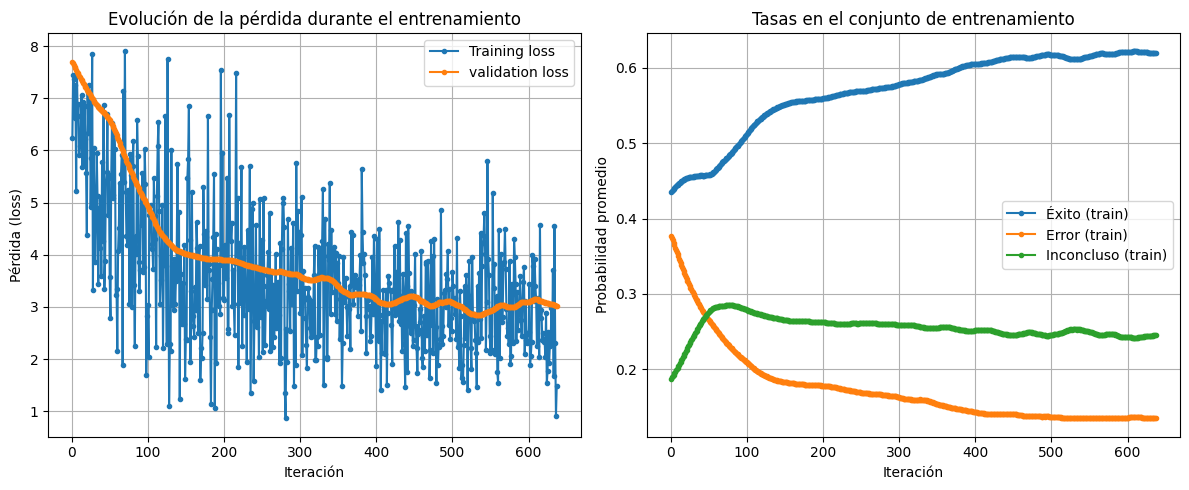

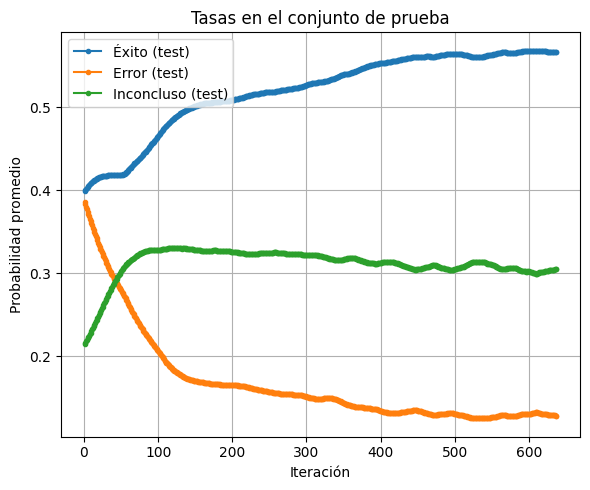

In [13]:
# Visualización de los resultados
plt.figure(figsize=(12,5))

# Evolución de la pérdida
plt.subplot(1,2,1)
plt.plot(range(1, it+1), loss_history, '.-', label="Training loss")
plt.plot(range(1, it+1), val_loss_history, '.-', label="validation loss")
plt.xlabel("Iteración")
plt.ylabel("Pérdida (loss)")
plt.title("Evolución de la pérdida durante el entrenamiento")
plt.grid()
plt.legend()

# Éxito, Error e Inconcluso en train
plt.subplot(1,2,2)
plt.plot(range(1, it+1), train_suc_history, '.-', label="Éxito (train)")
plt.plot(range(1, it+1), train_err_history, '.-', label="Error (train)")
plt.plot(range(1, it+1), train_inc_history, '.-', label="Inconcluso (train)")
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas en el conjunto de entrenamiento")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

# Figura para test
plt.figure(figsize=(6,5))

# Éxito, Error e Inconcluso en test
plt.plot(range(1, it+1), test_suc_history, '.-', label="Éxito (test)")
plt.plot(range(1, it+1), test_err_history, '.-', label="Error (test)")
plt.plot(range(1, it+1), test_inc_history, '.-', label="Inconcluso (test)")
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas en el conjunto de prueba")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

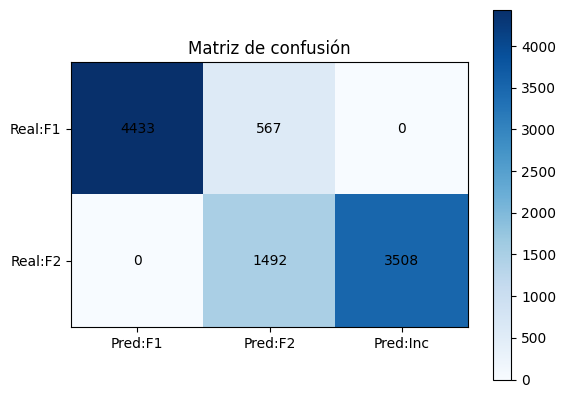

In [14]:
#Matriz de confusión

def predict_label(params, val, actual_label):
    """
    Devuelve la predicción discreta:
      1 => familia 1
      2 => familia 2
      3 => inconcluso


    actual_label se usa para saber qué outcome corresponde a éxito o error.
    """
    probs = get_probabilities(params, val, actual_label)

    p_fam1 = probs[0] + probs[2]
    p_fam2 = probs[1]
    p_inc  = probs[3]

    # Tomamos la mayor de las tres
    idx = np.argmax([p_fam1, p_fam2, p_inc])
    predicted = [1, 2, 3][idx]  # 1=fam1, 2=fam2, 3=inconcluso
    return predicted

def confusion_matrix_inconclusive(params, samples):

    cm = np.zeros((2, 3))
    for (val, actual_label) in samples:
        pred = predict_label(params, val, actual_label)
        row = actual_label - 1  # (1->0, 2->1)
        col = pred - 1          # (1->0, 2->1, 3->2)
        cm[row, col] += 1
    return cm

def plot_confusion_matrix_inconclusive(cm, normalize=False):
    """
    Dibuja la matriz
    """
    cm_display = cm.copy()
    if normalize:
        for i in range(cm_display.shape[0]):
            row_sum = np.sum(cm_display[i, :])
            if row_sum > 0:
                cm_display[i, :] /= row_sum


    fig, ax = plt.subplots()
    im = ax.imshow(cm_display, cmap='Blues', origin='upper')

    # Etiquetas de ejes
    ax.set_xticks([0,1,2])
    ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred:F1","Pred:F2","Pred:Inc"])
    ax.set_yticklabels(["Real:F1","Real:F2"])

    # Texto en cada celda
    for i in range(2):
        for j in range(3):
            val = cm_display[i, j]
            if normalize:
                txt = f"{val*100:.1f}%"
            else:
                txt = f"{val:.0f}"
            ax.text(j, i, txt, ha='center', va='center', color='black')

    plt.colorbar(im, ax=ax)
    plt.title("Matriz de confusión")
    plt.show()


cm_test = confusion_matrix_inconclusive(params, data_test)
plot_confusion_matrix_inconclusive(cm_test, normalize=False)
